In [1]:
from numpy import log2, sqrt
from numpy import pi

from qiskit.visualization import plot_histogram
from qiskit.circuit.gate import Gate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit import transpile

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

In [3]:
# QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token="Bd1FkANxtVrnUEd0OvGNO4maTi_BjvL_5HwTAggc63f0", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c06c79a6c7264eb7b56a25c9e1871dbd:0c4048eb-917d-4014-99ce-da28fd6498c9::")

In [4]:
service = QiskitRuntimeService()
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [28]:
def run(circuit, shots=1024):
    backend = service.backend('ibm_brisbane')
    transpiled = transpile(circuit, backend)
    sampler = Sampler(mode=backend)
    job = sampler.run([transpiled], shots=shots)
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    result = job.result()
    pub_result = result[0]
    counts = pub_result.join_data().get_counts()
    return counts

In [ ]:
# def run(circuit: QuantumCircuit, shots: int) -> dict:
#     # Mendapatkan backend simulator dari Aer
#     simulator = Aer.get_backend('aer_simulator')

#     # Transpile sirkuit untuk optimasi pada backend simulator
#     compiled_circuit = transpile(circuit, simulator)

#     # Menjalankan sirkuit
#     job = simulator.run(compiled_circuit, shots=shots)

#     # Mengambil hasil eksekusi
#     result = job.result()

#     # Mengembalikan kamus hasil pengukuran
#     return result.get_counts(compiled_circuit)

In [7]:
def init_register(bin_str: str) -> QuantumCircuit:
    data_qr = QuantumRegister(len(bin_str), 'data')
    qc = QuantumCircuit(data_qr)

    for i, bit in enumerate(bin_str):
        if bit == '1':
            qc.x(data_qr[i])

    return qc

In [8]:
def rot(n: int, s: int) -> QuantumCircuit:
    y_qr = QuantumRegister(n, 'y')
    qc = QuantumCircuit(y_qr, name='ROT_' + str(s))

    for i in range(1, (int(log2(n)) - int(log2(s)) + 2)):
        for j in range(int(n / (s * (2**i)))):
            for q in range(j * s * (2**i), s * (j*2 ** i+1)):
                qc.swap(n - 1 - (q+s), n - 1 - (q+2 ** (i-1) * s + s))

    return qc

In [9]:
def rot_gate(n: int, s: int) -> Gate:
    rot_circuit = rot(n, s)
    return rot_circuit.to_gate(label='ROT_' + str(s))

In [10]:
def parameterized_rot(n: int) -> QuantumCircuit:
    j_qr = QuantumRegister(int(log2(n)), 'j')
    y_qr = QuantumRegister(n, 'y')
    qc = QuantumCircuit(j_qr, y_qr)

    for i in range(int(log2(n))):
        crot = rot_gate(n, 2**i).control(1)
        qc = qc.compose(crot, [j_qr[i]] + y_qr[:])

    return qc

In [11]:
def match_gate_improved(m: int, pattern_x: str) -> Gate:
    """
    Membuat gerbang oracle 'match' yang membandingkan slice dari register 'y'
    dengan pola klasik 'pattern_x' yang di-hardcode.
    """
    y_qr = QuantumRegister(m, 'y')
    out_qr = QuantumRegister(1, 'out')
    qc = QuantumCircuit(y_qr, out_qr, name=f"MATCH_{pattern_x}")

    # Terapkan gerbang X pada qubit y jika bit pola adalah '0'.
    # Ini untuk menyamakan semua kondisi match menjadi |11...1>
    for i in range(m):
        if pattern_x[i] == '0':
            qc.x(y_qr[i])

    # Gunakan multi-controlled X untuk membalik qubit output jika semua match
    qc.mcx(y_qr[:], out_qr[0])

    # Uncomputation: Kembalikan gerbang X yang tadi diterapkan
    for i in range(m):
        if pattern_x[i] == '0':
            qc.x(y_qr[i])

    return qc.to_gate()

In [12]:
def diffuser(n: int) -> Gate:
    qc = QuantumCircuit(n)

    qc.h(range(n))
    qc.x(range(n))

    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)

    qc.x(range(n))
    qc.h(range(n))

    return qc.to_gate(label='DIFF')

In [13]:
def esm_oracle_improved(m: int, n: int, pattern_x: str) -> Gate:
    """Membangun oracle ESM (Exact String Match) yang dioptimalkan."""
    j_qr = QuantumRegister(int(log2(n)), 'j')
    y_qr = QuantumRegister(n, 'y')
    out_qr = QuantumRegister(1, 'out')
    
    qc = QuantumCircuit(j_qr, y_qr, out_qr)

    # 1. Rotasi teks berdasarkan register posisi 'j'
    qc.append(parameterized_rot(n).to_gate(), j_qr[:] + y_qr[:])
    
    # 2. Terapkan oracle match pada slice pertama dari teks yang sudah dirotasi
    qc.append(match_gate_improved(m, pattern_x), y_qr[:m] + out_qr[:])

    # 3. Uncomputation rotasi
    qc.append(parameterized_rot(n).inverse().to_gate(), j_qr[:] + y_qr[:])
    
    return qc.to_gate(label='ESMO_imp')

In [14]:
def grover_improved(t: int, x: str, y: str) -> QuantumCircuit:
    """Versi Grover yang dioptimalkan dengan kebutuhan qubit lebih sedikit."""
    n = len(y)
    m = len(x)
    logn = int(log2(n))
    
    # Hitung jumlah iterasi optimal
    num_iterations = int(pi/4 * sqrt(n/t))
    if num_iterations == 0: num_iterations = 1

    # Buat Oracle yang sudah dioptimalkan
    esmo_imp = esm_oracle_improved(m, n, x)

    # Definisikan register kuantum (lebih sedikit)
    j_qr = QuantumRegister(logn, 'j')
    y_qr = QuantumRegister(n, 'y')
    out_qr = QuantumRegister(1, 'out') # Hanya 1 qubit output
    c_qr = ClassicalRegister(logn, 'c')
    
    qc = QuantumCircuit(j_qr, y_qr, out_qr, c_qr)
    
    # Inisialisasi state
    qc.h(j_qr)
    qc.x(out_qr)
    qc.h(out_qr)
    
    # Inisialisasi teks y (pola x tidak perlu register)
    qc.append(init_register(y), y_qr[:])
    
    # Loop Grover
    diff = diffuser(logn)
    for _ in range(num_iterations):
        qc.append(esmo_imp, j_qr[:] + y_qr[:] + out_qr[:])
        qc.append(diff, j_qr[:])
        
    # Pengukuran
    qc.measure(j_qr, c_qr)
    
    return qc


Membangun sirkuit Grover untuk menemukan 2 solusi...
Waktu eksekusi pencarian kuantum: 1.417332 detik

--- Hasil Pencarian Kuantum ---
✅ Pola ditemukan pada posisi (indeks): [5, 9]
Jumlah solusi yang ditemukan: 2

Distribusi probabilitas hasil pengukuran:


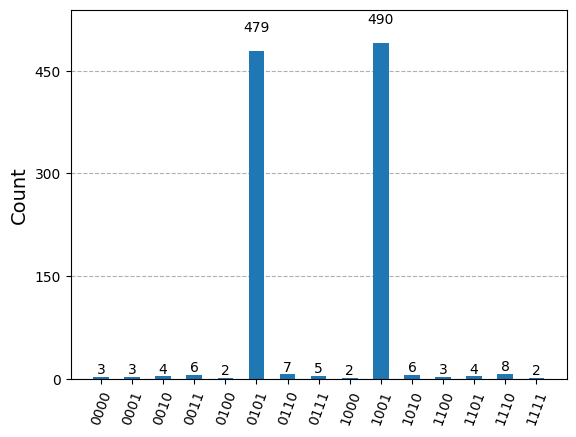

In [15]:
# IBM
import time
import operator

# Definisikan pola dan teks Anda
x = "10"
y = "1111110111011111"
m = len(x)
N = len(y)
t = 2

# --- LANGKAH 1: Bangun dan jalankan sirkuit Grover ---
print(f"\nMembangun sirkuit Grover untuk menemukan 2 solusi...")
quantum_circuit = grover_improved(t, x, y)

# Jalankan sirkuit
start_time = time.time()
# Menambah jumlah shots untuk hasil yang lebih stabil
shots = 1024 
counts = run(quantum_circuit, shots=shots)
end_time = time.time()
print(f"Waktu eksekusi pencarian kuantum: {end_time - start_time:.6f} detik")
print("\n--- Hasil Pencarian Kuantum ---")

# --- LANGKAH 2 : Proses hasil untuk menampilkan lokasi ---

# 1. Urutkan hasil berdasarkan jumlah pengukuran (probabilitas)
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

# 2. Filter hasil yang memiliki probabilitas signifikan (threshold)
threshold = shots * 0.1  # Minimal 10% dari total shots
significant_results = [(pos, count) for pos, count in sorted_counts if count >= threshold]

# 3. Ambil maksimal 't' hasil yang signifikan
actual_results = significant_results[:t] if len(significant_results) >= t else significant_results

# 4. Konversi hasil biner ke desimal dan kumpulkan posisinya
found_positions = [int(pos, 2) for pos, count in actual_results]
found_positions.sort()

# 5. Tampilkan hasilnya
if found_positions:
    print(f"✅ Pola ditemukan pada posisi (indeks): {found_positions}")
    print(f"Jumlah solusi yang ditemukan: {len(found_positions)}")
else:
    print("❌ Pola tidak ditemukan.")

print("\nDistribusi probabilitas hasil pengukuran:")
plot_histogram(counts)


Membangun sirkuit Grover untuk menemukan 2 solusi...
Waktu eksekusi pencarian kuantum: 1.512470 detik

--- Hasil Pencarian Kuantum ---
✅ Pola ditemukan pada posisi (indeks): [9]
Jumlah solusi yang ditemukan: 1

Distribusi probabilitas hasil pengukuran:


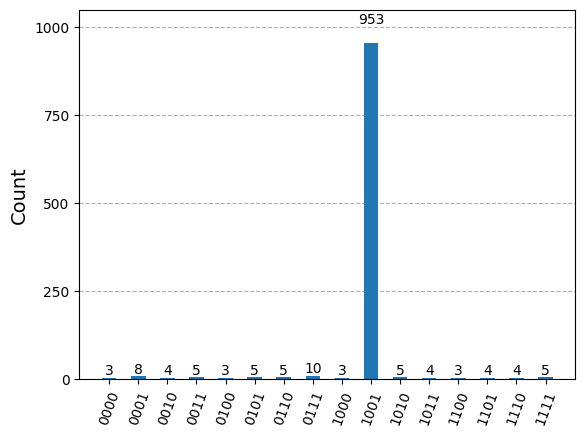

In [16]:
# Aer Simulator 1 solution
import time
import operator

# Definisikan pola dan teks Anda
x = "10"
y = "1111111111011111"
m = len(x)
N = len(y)
t = 2

# --- LANGKAH 1: Bangun dan jalankan sirkuit Grover ---
print(f"\nMembangun sirkuit Grover untuk menemukan 2 solusi...")
quantum_circuit = grover_improved(t, x, y)

# Jalankan sirkuit
start_time = time.time()
# Menambah jumlah shots untuk hasil yang lebih stabil
shots = 1024 
counts = run(quantum_circuit, shots=shots)
end_time = time.time()
print(f"Waktu eksekusi pencarian kuantum: {end_time - start_time:.6f} detik")
print("\n--- Hasil Pencarian Kuantum ---")

# --- LANGKAH 2 : Proses hasil untuk menampilkan lokasi ---

# 1. Urutkan hasil berdasarkan jumlah pengukuran (probabilitas)
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

# 2. Filter hasil yang memiliki probabilitas signifikan (threshold)
threshold = shots * 0.1  # Minimal 10% dari total shots
significant_results = [(pos, count) for pos, count in sorted_counts if count >= threshold]

# 3. Ambil maksimal 't' hasil yang signifikan
actual_results = significant_results[:t] if len(significant_results) >= t else significant_results

# 4. Konversi hasil biner ke desimal dan kumpulkan posisinya
found_positions = [int(pos, 2) for pos, count in actual_results]
found_positions.sort()

# 5. Tampilkan hasilnya
if found_positions:
    print(f"✅ Pola ditemukan pada posisi (indeks): {found_positions}")
    print(f"Jumlah solusi yang ditemukan: {len(found_positions)}")
else:
    print("❌ Pola tidak ditemukan.")

print("\nDistribusi probabilitas hasil pengukuran:")
plot_histogram(counts)


Membangun sirkuit Grover untuk menemukan 2 solusi...
Waktu eksekusi pencarian kuantum: 1.326609 detik

--- Hasil Pencarian Kuantum ---
✅ Pola ditemukan pada posisi (indeks): [5, 9]
Jumlah solusi yang ditemukan: 2

Distribusi probabilitas hasil pengukuran:


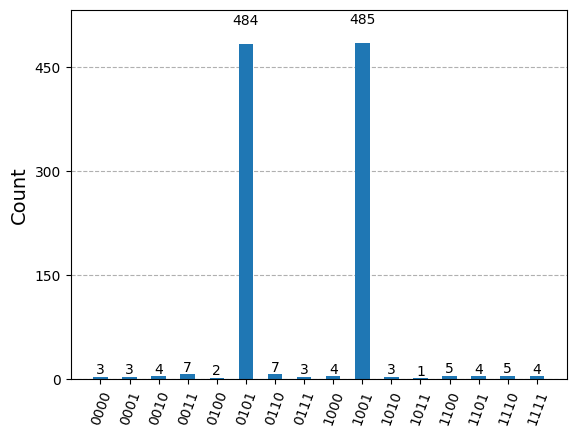

In [17]:
# Aer Simulator 2 solution
import time
import operator

# Definisikan pola dan teks Anda
x = "10"
y = "1111110111011111"
m = len(x)
N = len(y)
t = 2

# --- LANGKAH 1: Bangun dan jalankan sirkuit Grover ---
print(f"\nMembangun sirkuit Grover untuk menemukan 2 solusi...")
quantum_circuit = grover_improved(t, x, y)

# Jalankan sirkuit
start_time = time.time()
# Menambah jumlah shots untuk hasil yang lebih stabil
shots = 1024 
counts = run(quantum_circuit, shots=shots)
end_time = time.time()
print(f"Waktu eksekusi pencarian kuantum: {end_time - start_time:.6f} detik")
print("\n--- Hasil Pencarian Kuantum ---")

# --- LANGKAH 2 : Proses hasil untuk menampilkan lokasi ---

# 1. Urutkan hasil berdasarkan jumlah pengukuran (probabilitas)
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

# 2. Filter hasil yang memiliki probabilitas signifikan (threshold)
threshold = shots * 0.1  # Minimal 10% dari total shots
significant_results = [(pos, count) for pos, count in sorted_counts if count >= threshold]

# 3. Ambil maksimal 't' hasil yang signifikan
actual_results = significant_results[:t] if len(significant_results) >= t else significant_results

# 4. Konversi hasil biner ke desimal dan kumpulkan posisinya
found_positions = [int(pos, 2) for pos, count in actual_results]
found_positions.sort()

# 5. Tampilkan hasilnya
if found_positions:
    print(f"✅ Pola ditemukan pada posisi (indeks): {found_positions}")
    print(f"Jumlah solusi yang ditemukan: {len(found_positions)}")
else:
    print("❌ Pola tidak ditemukan.")

print("\nDistribusi probabilitas hasil pengukuran:")
plot_histogram(counts)


Membangun sirkuit Grover untuk menemukan 2 solusi...
Waktu eksekusi pencarian kuantum: 1.309658 detik

--- Hasil Pencarian Kuantum ---
✅ Pola ditemukan pada posisi (indeks): [7, 9]
Jumlah solusi yang ditemukan: 2

Distribusi probabilitas hasil pengukuran:


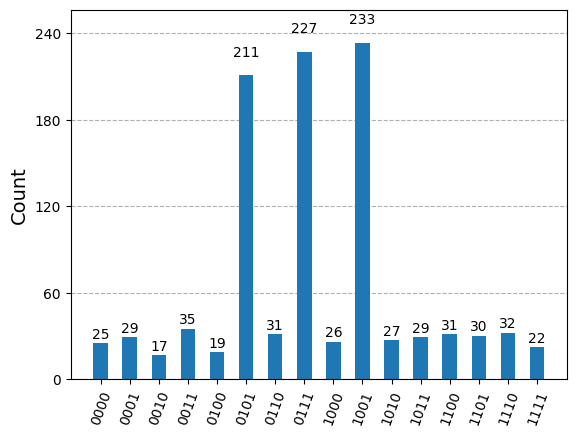

In [18]:
# Aer Simulator 3 solution
import time
import operator

# Definisikan pola dan teks Anda
x = "10"
y = "1111110101011111"
m = len(x)
N = len(y)
t = 2

# --- LANGKAH 1: Bangun dan jalankan sirkuit Grover ---
print(f"\nMembangun sirkuit Grover untuk menemukan 2 solusi...")
quantum_circuit = grover_improved(t, x, y)

# Jalankan sirkuit
start_time = time.time()
# Menambah jumlah shots untuk hasil yang lebih stabil
shots = 1024 
counts = run(quantum_circuit, shots=shots)
end_time = time.time()
print(f"Waktu eksekusi pencarian kuantum: {end_time - start_time:.6f} detik")
print("\n--- Hasil Pencarian Kuantum ---")

# --- LANGKAH 2 : Proses hasil untuk menampilkan lokasi ---

# 1. Urutkan hasil berdasarkan jumlah pengukuran (probabilitas)
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

# 2. Filter hasil yang memiliki probabilitas signifikan (threshold)
threshold = shots * 0.1  # Minimal 10% dari total shots
significant_results = [(pos, count) for pos, count in sorted_counts if count >= threshold]

# 3. Ambil maksimal 't' hasil yang signifikan
actual_results = significant_results[:t] if len(significant_results) >= t else significant_results

# 4. Konversi hasil biner ke desimal dan kumpulkan posisinya
found_positions = [int(pos, 2) for pos, count in actual_results]
found_positions.sort()

# 5. Tampilkan hasilnya
if found_positions:
    print(f"✅ Pola ditemukan pada posisi (indeks): {found_positions}")
    print(f"Jumlah solusi yang ditemukan: {len(found_positions)}")
else:
    print("❌ Pola tidak ditemukan.")

print("\nDistribusi probabilitas hasil pengukuran:")
plot_histogram(counts)

In [ ]:
# from numba import jit
# import time

# @jit(forceobj=True)
# def concatenate_with_numba(lines_list):
#     """
#     Menggabungkan list of strings menggunakan loop yang dikompilasi Numba.
#     Fungsi ini sekarang hanya menerima list sebagai input.
#     """
#     full_sequence = ""
#     count = 0
#     for line in lines_list:
#         full_sequence += line
#         count += 1
#         print(f"Memproses baris {count}: {line[:30]}...")  # Menampilkan potongan awal dari setiap baris
#     return full_sequence

# # Path ke file FASTA Anda
# fasta_path = '../ncbi_dataset/ncbi_dataset/data/GCA_000003195.3/GCA_000003195.3_Sorghum_bicolor_NCBIv3_genomic.fna'

# # --- Langkah 1: Membaca file menggunakan Python standar ---
# lines_of_interest = []
# try:
#     with open(fasta_path, 'r') as f:
#         next(f)  # Melewati baris header
#         count = 0
#         for line in f:
#             if line.startswith('>'):
#                 break
#             lines_of_interest.append(line.strip())
#             count += 1
#         print(f"Berhasil membaca {count} baris dari file FASTA.")
# except FileNotFoundError:
#     print(f"Error: File tidak ditemukan di '{fasta_path}'")
#     lines_of_interest = [] # Pastikan list kosong jika file tidak ada

# # --- Langkah 2: Menggabungkan list menggunakan fungsi Numba ---
# if lines_of_interest:
#     print("Menggabungkan sekuens dengan Numba...")
#     start_time = time.time()
#     sequence_numba = concatenate_with_numba(lines_of_interest)
#     end_time = time.time()
#     print(f"Selesai dalam {end_time - start_time:.4f} detik.")
#     print(f"Panjang sekuens: {len(sequence_numba)}")
# else:
#     print("Tidak ada sekuens yang dibaca, proses penggabungan dilewati.")

Berhasil membaca 1011055 baris dari file FASTA.
Menggabungkan sekuens dengan Numba...
Memproses baris 1: GATCGATGCTCCTGTGCTCCCaacccctaa...
Memproses baris 2: ccctaaaaccctaaaccctaaaccctaaac...
Memproses baris 3: ACCTATTTAAACTGAGTTAATAAAAGATCA...
Memproses baris 4: cctataattaattattatcaAATAATATAT...
Memproses baris 5: GAAGCCAATTAAGTATTAAAATAGTTGAAG...
Memproses baris 6: gaatctttatacgcatgcatagattattaa...
Memproses baris 7: GTATTTAGGGGGTGCAAATGCACCCCCAAA...
Memproses baris 8: ATAACACAAGTCTATATATCTATGAGCCAA...
Memproses baris 9: ttgtctataatttacgagacgaatcttttg...
Memproses baris 10: TTTTTTTTCGAACTGAACAAGGTCTTGACA...
Memproses baris 11: AGGAGTTGGAATAAAGAAACTTGGTGTCAG...
Memproses baris 12: ATGTTGCGTGTTTTGGGGGCTAGGCCAGGG...
Memproses baris 13: AGGGAAGCCGTCAAGCGAAGGGAAGGGAAG...
Memproses baris 14: GCTTccacttaggtcttgtttagatcttaA...
Memproses baris 15: ttgtcaaattataaagtaactatgcttaaa...
Memproses baris 16: atctatatttaatgttccatacaagtgcca...
Memproses baris 17: ATTAAAAAAGGCCTTAATAATATAGAGCTA...
Mempr

In [20]:
import time

def concatenate(lines_list):
    """
    Menggabungkan list of strings menggunakan loop yang dikompilasi Numba.
    Fungsi ini sekarang hanya menerima list sebagai input.
    """
    full_sequence = ""
    count = 0
    for line in lines_list:
        full_sequence += line
        count += 1
        print(f"Memproses baris {count}: {line[:30]}...")  # Menampilkan potongan awal dari setiap baris
    return full_sequence

# Path ke file FASTA Anda
fasta_path = '../ncbi_dataset/ncbi_dataset/data/GCA_000003195.3/GCA_000003195.3_Sorghum_bicolor_NCBIv3_genomic.fna'

# --- Langkah 1: Membaca file menggunakan Python standar ---
lines_of_interest = []
try:
    with open(fasta_path, 'r') as f:
        next(f)  # Melewati baris header
        count = 0
        for line in f:
            if line.startswith('>'):
                break
            lines_of_interest.append(line.strip())
            count += 1
        print(f"Berhasil membaca {count} baris dari file FASTA.")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di '{fasta_path}'")
    lines_of_interest = [] # Pastikan list kosong jika file tidak ada

# --- Langkah 2: Menggabungkan list menggunakan fungsi Numba ---
if lines_of_interest:
    print("Menggabungkan sekuens dengan Numba...")
    start_time = time.time()
    sequence_numba = concatenate(lines_of_interest)
    end_time = time.time()
    print(f"Selesai dalam {end_time - start_time:.4f} detik.")
    print(f"Panjang sekuens: {len(sequence_numba)}")
else:
    print("Tidak ada sekuens yang dibaca, proses penggabungan dilewati.")

Berhasil membaca 1011055 baris dari file FASTA.
Menggabungkan sekuens dengan Numba...
Memproses baris 1: GATCGATGCTCCTGTGCTCCCaacccctaa...
Memproses baris 2: ccctaaaaccctaaaccctaaaccctaaac...
Memproses baris 3: ACCTATTTAAACTGAGTTAATAAAAGATCA...
Memproses baris 4: cctataattaattattatcaAATAATATAT...
Memproses baris 5: GAAGCCAATTAAGTATTAAAATAGTTGAAG...
Memproses baris 6: gaatctttatacgcatgcatagattattaa...
Memproses baris 7: GTATTTAGGGGGTGCAAATGCACCCCCAAA...
Memproses baris 8: ATAACACAAGTCTATATATCTATGAGCCAA...
Memproses baris 9: ttgtctataatttacgagacgaatcttttg...
Memproses baris 10: TTTTTTTTCGAACTGAACAAGGTCTTGACA...
Memproses baris 11: AGGAGTTGGAATAAAGAAACTTGGTGTCAG...
Memproses baris 12: ATGTTGCGTGTTTTGGGGGCTAGGCCAGGG...
Memproses baris 13: AGGGAAGCCGTCAAGCGAAGGGAAGGGAAG...
Memproses baris 14: GCTTccacttaggtcttgtttagatcttaA...
Memproses baris 15: ttgtcaaattataaagtaactatgcttaaa...
Memproses baris 16: atctatatttaatgttccatacaagtgcca...
Memproses baris 17: ATTAAAAAAGGCCTTAATAATATAGAGCTA...
Mempr

KeyboardInterrupt: 

--- Memulai Pencarian 1 ---
Panjang teks yang dicari: 120
Membangun sirkuit Grover untuk menemukan pola '10' dalam teks '111111010101111111111101010111111111110101011111111111010101111111111101010111111111110101011111111111010101111111111101'...
>>> Job ID: d2095qcrg24s738ogmh0
>>> Job Status: QUEUED
Waktu eksekusi pencarian 1: 452.089190 detik
--- Hasil Pencarian Kuantum 1 ---
❌ Pola '10' tidak ditemukan.
Distribusi probabilitas hasil pengukuran 1:


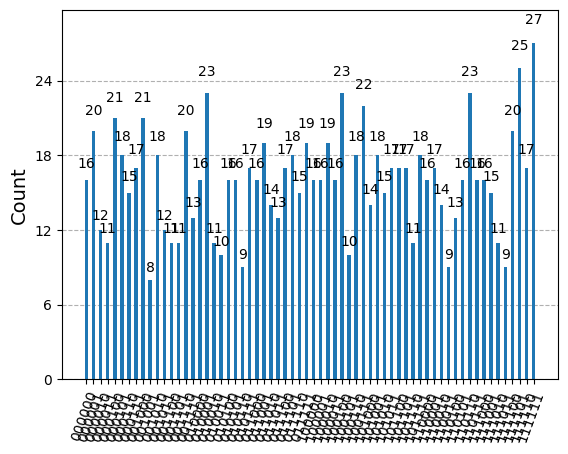

In [29]:
import time
import operator
from numpy import log2, sqrt, pi
from qiskit.visualization import plot_histogram

# Pastikan semua fungsi yang diperlukan (grover_improved, run, dll.)
# telah dieksekusi di sel-sel sebelumnya.

# --- Konfigurasi Pencarian ---
y = "111111010101111111111101010111111111110101011111111111010101111111111101010111111111110101011111111111010101111111111101"  # Teks yang akan dicari
t = 2  # Jumlah solusi yang diharapkan
shots = 1024
patterns_to_search = ["10"] # Daftar pola yang akan dicari

# --- Loop Pencarian ---
for i, x in enumerate(patterns_to_search):
    search_num = i + 1
    print(f"--- Memulai Pencarian {search_num} ---")
    print(f"Panjang teks yang dicari: {len(y)}")
    print(f"Membangun sirkuit Grover untuk menemukan pola '{x}' dalam teks '{y}'...")

    # Membangun sirkuit Grover untuk pola saat ini
    quantum_circuit = grover_improved(t, x, y)

    # Menjalankan sirkuit
    start_time = time.time()
    counts = run(quantum_circuit, shots=shots)
    end_time = time.time()

    print(f"Waktu eksekusi pencarian {search_num}: {end_time - start_time:.6f} detik")
    print(f"--- Hasil Pencarian Kuantum {search_num} ---")

    # Memproses dan menampilkan hasil
    sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    threshold = shots * 0.1
    significant_results = [(pos, count) for pos, count in sorted_counts if count >= threshold]
    actual_results = significant_results[:t] if len(significant_results) >= t else significant_results
    found_positions = sorted([int(pos, 2) for pos, count in actual_results])

    if found_positions:
        print(f"✅ Pola '{x}' ditemukan pada posisi (indeks): {found_positions}")
        print(f"Jumlah solusi yang ditemukan: {len(found_positions)}")
    else:
        print(f"❌ Pola '{x}' tidak ditemukan.")

    print(f"Distribusi probabilitas hasil pengukuran {search_num}:")
    display(plot_histogram(counts))
    print("="*50)